# Predict substructure fingerprints from spectra

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import csv

import numpy as np
import pandas as pd

import keras
from keras.callbacks import History, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from livelossplot import PlotLossesKeras

from ms2lda_feature_extraction import LoadMSP, LoadGNPS, LoadMGF, LoadGNPSSeperateCollisions
from functions import *

Using TensorFlow backend.


### Load GNPS+Massbank data

Data contains SMILES of known molecules and also their fragmentation spectra from massbank + gnps.

Collision energies are merged.

In [3]:
# input_dir = '../data/fingerid-104-traindata/spectra_gnps_massbank'
# input_set = glob.glob(input_dir + '/*.ms')
# l = LoadGNPS()
# ms1, ms2, metadata = l.load_spectra(input_set)

In [4]:
# def make_spec_matrix(ms1, ms2, min_frag_mz=20, max_frag_mz=500, normalise=1000.0):
#     doc_index = {}
#     n_docs = len(ms1)
#     i = 0
#     for m in ms1:
#         doc_index[m.name] = i
#         i += 1
#     n_words = max_frag_mz - min_frag_mz + 1
#     n_docs = len(doc_index)
#     doc_matrix = np.zeros((n_docs,n_words),np.double)
#     for m in ms2:
#         mz = m[0]
#         mz_int = (int)(np.round(mz))
#         doc_pos = doc_index[m[3].name]
#         if mz_int <= max_frag_mz and mz_int >= min_frag_mz:
#             mz_pos = mz_int - min_frag_mz
#             doc_matrix[doc_pos,mz_pos] += m[2]
            
#     s = doc_matrix.sum(axis=1)
#     toremove = []
#     for doc,doc_pos in doc_index.items():
#         if s[doc_pos] == 0:
#             toremove.append(doc)
    
#     for doc in toremove:
#         doc_pos = doc_index[doc]
#         doc_matrix = np.delete(doc_matrix,(doc_pos),axis=0)
#         del doc_index[doc]
#         for d,p in doc_index.items():
#             if p > doc_pos:
#                 doc_index[d] -= 1
    
#     if normalise > 0:
#         s = doc_matrix.max(axis=1)
#         s = s[:,None]
#         doc_matrix *= (normalise/s)

#     return doc_index, doc_matrix

In [5]:
# min_frag_mz = 20
# max_frag_mz = 900
# normalise = 1.0
# spectra_index, spectra_matrix = make_spec_matrix(ms1, ms2, min_frag_mz, max_frag_mz, normalise)

Load pre-binned data using the code above

In [6]:
import pickle
with open('../data/gnps_massbank_data.p', 'rb') as f:
    data = pickle.load(f)

In [7]:
spectra = data['spectra']

### Create  Fingerprints of Molecules

Load substructures fingerprints generated by CDK for the smiles corresponding to the spectra above.

In [8]:
fprints = {}
with open('../data/smiles_sub.csv','r') as f:
    reader = csv.reader(f)
    for line in reader:
        fprints[line[0]] = [int(i) for i in line[1:]]

In [9]:
smiles = data['smiles']
fingerprint_arr = np.zeros((len(smiles), 306+1))
for i in range(len(smiles)):
    smile = smiles[i]
    fingerprint = fprints[smile]
    for bit in fingerprint:
        fingerprint_arr[i][bit] = 1

(7901, 881)


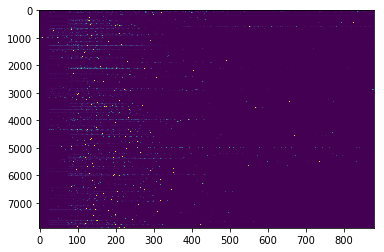

In [10]:
print(spectra.shape)
plt.imshow(spectra,aspect='auto')

(7901, 307)


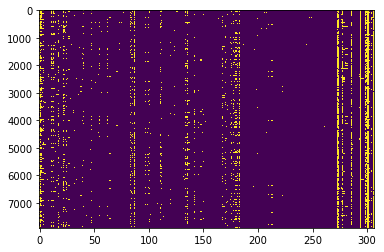

In [11]:
print(fingerprint_arr.shape)
plt.imshow(fingerprint_arr,aspect='auto')

Plot some spectra and their fingerprints

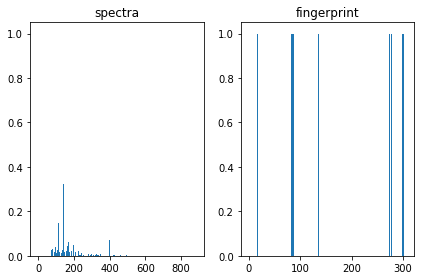

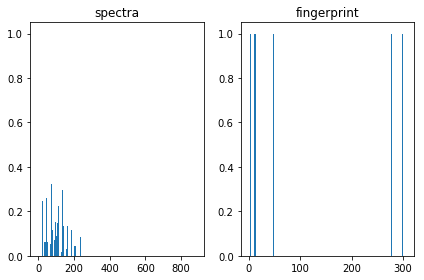

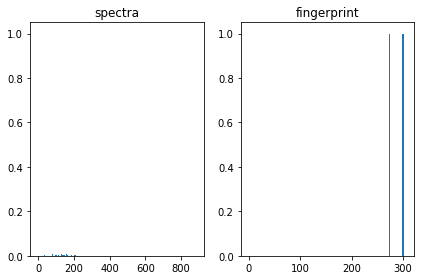

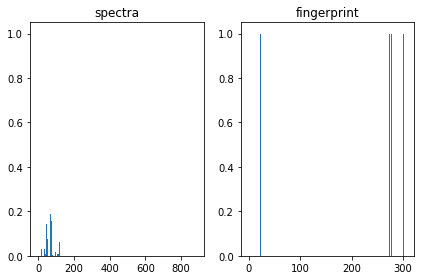

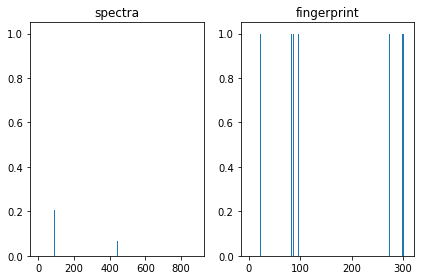

In [12]:
def plot_spectra_and_fingerprint(idx):
    plt.subplot(121)
    plt.bar(np.arange(len(spectra[idx])), spectra[idx])
    plt.title('spectra')
    plt.subplot(122)
    plt.bar(np.arange(len(fingerprint_arr[idx])), fingerprint_arr[idx])
    plt.title('fingerprint')
    plt.tight_layout()
    plt.show()
    
for i in range(5):
    plot_spectra_and_fingerprint(i)

### Filtering

In [13]:
substructures = []
with open('../data/substructures.txt','r') as f:
    for line in f:
        substructures.append(line.strip())

In [14]:
s = fingerprint_arr.sum(axis=0)
sub_count = []
for i, sub in enumerate(substructures):
    sub_count.append((i, sub, s[i]))

sub_count = sorted(sub_count,key = lambda x: x[1],reverse = True)
df = pd.DataFrame(sub_count, columns=['pos', 's', 'c'])
df = df.sort_values(by=['c'], ascending=False)

In [15]:
df.head(10)

,pos,s,c
265,294,"[#6]~[#7,#8,#16]",7897.0
240,306,"[$([*@](~*)(~*)(*)*),$([*@H](*)(*)*),$([*@](~*...",7753.0
298,301,[!$(*#*)&!D1]-!@[!$(*#*)&!D1],7351.0
0,273,a,6603.0
300,274,[!#6;!R0],5970.0
243,299,"[$([#7X2,OX1,SX1]=*[!H0;!$([a;!n])]),$([#7X3,O...",5379.0
185,1,[CX4H2]([#6])[#6],4889.0
302,286,"*=*[*]=,#,:[*]",4753.0
246,87,"[$([#6X3H0][#6]),$([#6X3H])](=[!#6])[!#6]",4681.0
184,0,[CX4H3][#6],4657.0


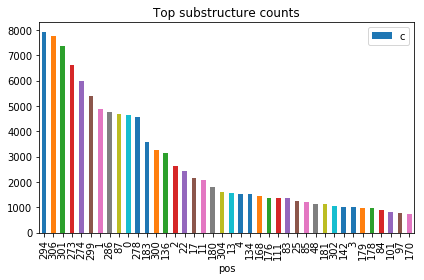

In [16]:
df.head(40).plot(kind='bar', x='pos', y='c')
plt.title('Top substructure counts')
plt.tight_layout()

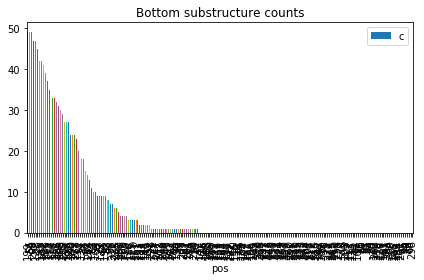

In [17]:
df.tail(200).plot(kind='bar', x='pos', y='c')
plt.title('Bottom substructure counts')
plt.tight_layout()

We use only substructures with lower < counts < upper for the target predictions

In [18]:
lower = 10
upper = 3000

In [19]:
keep = df[(df['c'] > lower) & (df['c'] < upper)]
print(keep.shape)

(127, 3)


Text(0.5,1,'Substructures 10 < counts < 3000')

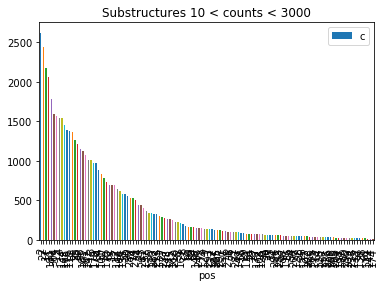

In [20]:
keep.plot(kind='bar', x='pos', y='c')
plt.title('Substructures %d < counts < %d' % (lower, upper))

Select rows and columns to keep from fp_mat and spectra

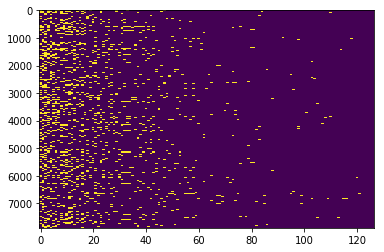

In [21]:
keep_idx = keep['pos'].values
fp_mat = fingerprint_arr[:, keep_idx]

nnz_pos = ~(fp_mat==0).all(1) # find rows that are not all zeros
fp_mat = fp_mat[nnz_pos]
spectra = spectra[nnz_pos]

plt.imshow(fp_mat,aspect='auto')

### Try mapping spectra to fingerprints

In [48]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001,
                        verbose=1, epsilon=1e-5)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
callbacks = [rlr, early_stop]
if is_notebook():
    callbacks.append(PlotLossesKeras())

/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/keras/callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '


In [87]:
input_dim = spectra.shape[1]
output_dim = fp_mat.shape[1]
latent_dim = 64
batch_size = 32
epochs = 100

In [88]:
def get_model(input_dim, output_dim, latent_dim):

    input_layer = Input(shape=(input_dim,))
    encoded = Dense(latent_dim, activation='tanh')(input_layer)
    decoded = Dense(output_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)

    encoder = Model(input_layer, encoded)

    encoded_input = Input(shape=(latent_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))

    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    return autoencoder, encoder, decoder

Input: peak intensities, binned by their m/z integer values

Output: substructural fingerprint bits

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 881)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                56448     
_________________________________________________________________
dense_20 (Dense)             (None, 127)               8255      
Total params: 64,703
Trainable params: 64,703
Non-trainable params: 0
_________________________________________________________________


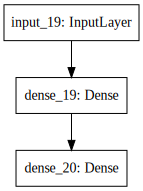

In [89]:
autoencoder, encoder, decoder = get_model(input_dim, output_dim, latent_dim)
autoencoder.summary()
plot_model_in_notebook(autoencoder)

In [90]:
pos = int(len(spectra) * 0.8)
spectra_train = spectra[0:pos, :]
spectra_test = spectra[pos:, :]
fingerprint_train = fp_mat[0:pos, :]
fingerprint_test = fp_mat[pos:, :]

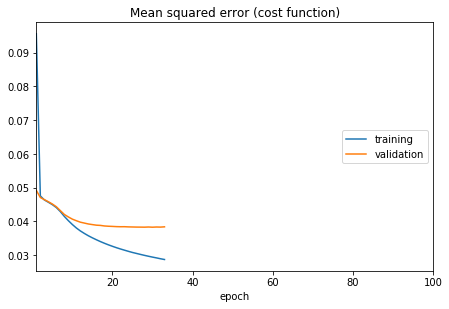

Epoch 00033: early stopping


In [91]:
autoencoder.fit(spectra_train, fingerprint_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(spectra_test, fingerprint_test),
                callbacks=callbacks)

In [92]:
latent = encoder.predict(spectra_test)
predicted_fingerprint = decoder.predict(latent)

### Compute precision, recall, f1

In [93]:
total_tp = 0
total_fp = 0
total_fn = 0
for i in range(len(fingerprint_test)):
    
    y_pred = np.round(predicted_fingerprint[i])
    y_true = fingerprint_test[i]    
    y_pred_nnz = set(np.nonzero(y_pred)[0].tolist())
    y_true_nnz = set(np.nonzero(y_true)[0].tolist())    
    
    # tp = selected and relevant
    tp = y_pred_nnz & y_true_nnz
    total_tp += len(tp)
    
    # fp = selected but not relevant
    fp = y_pred_nnz - y_true_nnz
    total_fp += len(fp)
    
    # fn = not selected but relevant
    fn = y_true_nnz - y_pred_nnz
    total_fn += len(fn)

#     print('y_true_nnz', y_true_nnz, 'y_pred_nnz', y_pred_nnz)
#     print('tp', tp)
#     print('fp', fp)
#     print('fn', fn)        
#     print()       
#     plt.bar(np.arange(len(y_true)), y_true)
#     plt.bar(np.arange(len(y_pred)), -y_pred)
#     plt.show()    

In [94]:
precision = total_tp / float(total_tp + total_fp)
recall = total_tp / float(total_tp + total_fn)
f1 = 2 * (precision * recall) / (precision + recall)
print('precision %.2f recall %.2f f1 %.2f' % (precision, recall, f1))

precision 0.60 recall 0.31 f1 0.41
